# D'Espagnat experiment simulation

In [40]:
import strawberryfields as sf
from strawberryfields.ops import *
import numpy as np
from numpy import pi, sqrt
import matplotlib.pyplot as plt

np.random.seed(42)

In [81]:
#========= Simulation parameters ============

n_paths = 1
n_modes = n_paths*2
cutoff_dim = 2
N = 10 # half-number of photons per box
Ntrials = 2000

#======== Initial State Preparation ==========

# Vacuum State Array
VacuumState = np.zeros([cutoff_dim] * n_modes, dtype='complex')

def SingleQubitStateIn(theta1, phi1):
    State = np.copy(VacuumState)
    
    State[1,0] = np.cos(theta1/2)
    State[0,1] = np.sin(theta1/2)*np.exp(1j*phi1)
    
    return State

SinglePhotonStateDict = {
    "H" : SingleQubitStateIn(0., 0.),
    "V" : SingleQubitStateIn(pi, 0.),
    "D" : SingleQubitStateIn(pi/2, 0.),
    "A" : SingleQubitStateIn(pi/2, pi),
    "L" : SingleQubitStateIn(pi/2, pi/2),
    "R" : SingleQubitStateIn(pi/2,-pi/2)
}

MaxMixedState = np.zeros([cutoff_dim,cutoff_dim] * n_modes, dtype='complex')
MaxMixedState[1,1,0,0] = 1/2
MaxMixedState[0,0,1,1] = 1/2

MaxMixedState = DensityMatrix(MaxMixedState)

In [82]:
#=========== Circuit construction (for pure states) ============

PuredEspagnatProg = sf.Program(n_modes)
InitialState = PuredEspagnatProg.params('InitialState')

with PuredEspagnatProg.context as q:
    # prepare initial state
    Ket(InitialState) | q
    
    # measure
    MeasureFock() | q
    
MixeddEspagnatProg = sf.Program(n_modes)

with MixeddEspagnatProg.context as q:
    # prepare initial state
    MaxMixedState | q

    # measure
    MeasureFock() | q
    
eng = sf.Engine('fock', backend_options={"cutoff_dim": cutoff_dim})

In [83]:
photons = np.array(["H"]*N + ["V"]*N)
np.random.shuffle(photons)

NHA = np.zeros(Ntrials)

for t in range(Ntrials):
    for s in photons:
        init_state = SinglePhotonStateDict[s]
        result = eng.run(PuredEspagnatProg, args={'InitialState': init_state})
        NHA[t] += result.samples[0][0]

In [84]:
photons = np.array(["L"]*N + ["R"]*N)
np.random.shuffle(photons)

NHB = np.zeros(Ntrials)

for t in range(Ntrials):
    for s in photons:
        init_state = SinglePhotonStateDict[s]
        result = eng.run(PuredEspagnatProg, args={'InitialState': init_state})
        NHB[t] += result.samples[0][0]

In [85]:
NHC = np.zeros(Ntrials)

for t in range(Ntrials):
    for s in photons:
        result = eng.run(MixeddEspagnatProg)
        NHC[t] += result.samples[0][0]

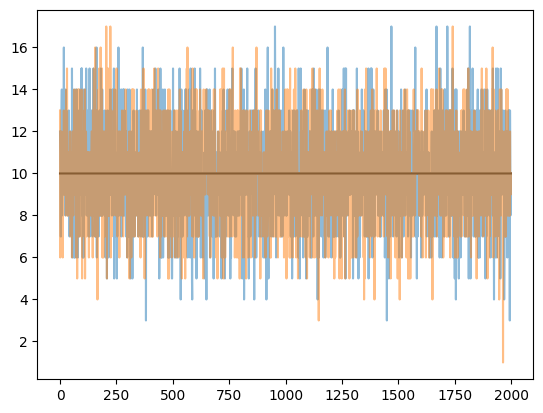

In [86]:
plt.plot(range(Ntrials), NHA, color='k')
plt.plot(range(Ntrials), NHB, alpha = 0.5)
plt.plot(range(Ntrials), NHC, alpha = 0.5)
plt.show()

In [87]:
print(np.mean(NHA))
print(np.mean(NHB))
print(np.mean(NHC))

10.0
10.014
10.0275


In [88]:
print(np.var(NHA, ddof=1))
print(np.var(NHB, ddof=1))
print(np.var(NHC, ddof=1))

0.0
5.212410205102551
5.019253376688344
